# Location Dataset: Analysis - Model Training - Model Evalutaion

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from pandas_profiling import ProfileReport
from pandas.api.types import CategoricalDtype
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, f1_score
#plt.style.use('seaborn-whitegrid')
%matplotlib inline

np.random.seed(42)

## Data exploration & pre-processing

In [2]:
df = pd.read_csv("../data/kaggle_location_dataset/Location446-30cls-5k.lrn.csv")
df.head(5)

ID  class  1  2  3  4  5  6  7  8  ...  437  438  439  440  441  442  443  \
0   0     11  0  0  0  1  1  0  0  0  ...    0    0    0    0    1    0    0   
1   1      3  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
2   2      9  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
3   3      8  0  0  0  1  0  0  0  0  ...    0    0    0    0    1    0    0   
4   4      3  0  1  0  0  0  0  0  0  ...    0    0    0    0    0    0    1   

   444  445  446  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0  

[5 rows x 448 columns]

In [3]:
geosocial_type = CategoricalDtype(categories=[f"{i}" for i in range(1, 31)], ordered=True)
df['class'] = df['class'].apply(str).astype(geosocial_type)
df.astype('object').describe()

ID class     1     2     3     4     5     6     7     8  ...   437  \
count   4000  4000  4000  4000  4000  4000  4000  4000  4000  4000  ...  4000   
unique  4000    30     2     2     2     2     2     2     2     2  ...     2   
top     3999     8     0     0     0     1     0     0     0     0  ...     0   
freq       1   250  3775  3283  3808  2124  3616  3572  3880  3773  ...  3854   

         438   439   440   441   442   443   444   445   446  
count   4000  4000  4000  4000  4000  4000  4000  4000  4000  
unique     2     2     2     2     2     2     2     2     2  
top        0     0     0     0     0     0     0     0     0  
freq    3792  3830  3810  3758  3812  3190  3741  3504  3761  

[4 rows x 448 columns]

In [4]:
df = df.drop("ID", axis=1)
df.head(5)

class  1  2  3  4  5  6  7  8  9  ...  437  438  439  440  441  442  443  \
0    11  0  0  0  1  1  0  0  0  0  ...    0    0    0    0    1    0    0   
1     3  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
2     9  0  0  0  0  0  0  0  0  1  ...    0    0    0    0    0    0    0   
3     8  0  0  0  1  0  0  0  0  0  ...    0    0    0    0    1    0    0   
4     3  0  1  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    1   

   444  445  446  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0  

[5 rows x 447 columns]

Checking for duplicate columns, rows and whether there are rows missclassified:

In [5]:
duplicate_columns = False
for col1 in df.columns:
    for col2 in df.columns:
        if col1 != col2 and df[col1].equals(df[col2]):
            print(f"{col1} and {col2} are the same")
            duplicate_columns = True
print(f"Are there any duplicate columns? - {duplicate_columns}")
print(f"Are there any duplicate rows? - {df.duplicated().any()}")
col_names = df.columns[1:]
print(f"Are there any missclassified rows? - {df.duplicated(subset = col_names).any()}")

Are there any duplicate columns? - False
Are there any duplicate rows? - False
Are there any missclassified rows? - False


Lets have a look at the distribution of the target variable

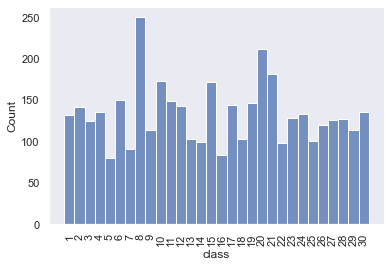

In [14]:
sns.set_theme()
sns.set_style("dark")
sns.histplot(data=df, x="class")
plt.xticks(rotation=90)
#plt.title("Histogram for the class variable")
#plt.ylabel("Sample Count")
plt.xlabel("class")
plt.savefig('class_variable.png', dpi=300)

In [41]:
class_counts = df["class"].value_counts().sort_index()
class_counts.to_csv("class_counts.csv")
class_counts

1     132
2     141
3     124
4     135
5      80
6     150
7      90
8     250
9     114
10    173
11    149
12    142
13    103
14     99
15    171
16     83
17    144
18    103
19    146
20    211
21    181
22     98
23    128
24    133
25    100
26    119
27    126
28    127
29    113
30    135
Name: class, dtype: int64

Lets have a look at some of the explanatory variables

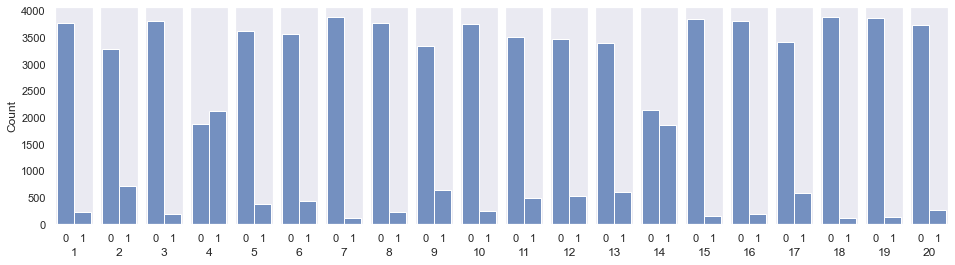

In [42]:
visited_type = CategoricalDtype(categories=["0", "1"], ordered=True)
plot_df = df.copy()
for i in range(1, 31):
    plot_df[f'{i}'] = plot_df[f'{i}'].apply(str).astype(visited_type)

number_of_locations = 20

fig, axs = plt.subplots(1, number_of_locations, sharey=True, figsize=(16, 4))
for i in range(1, number_of_locations+1):
    sns.histplot(data=plot_df, x=f"{i}", ax=axs[i-1])

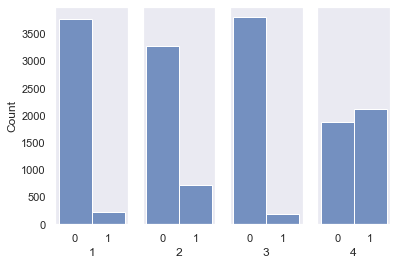

In [43]:
fig, axs = plt.subplots(1, 4, sharey=True)
for j, i in enumerate(["1", "2", "3", "4"]):
    sns.histplot(data=plot_df, x=f"{i}", ax=axs[j])
plt.savefig(f'locations.png')
plt.show()

We observe that most variables are heavily skewed. Are there some where this is very extreme?

In [44]:
df.sum(axis=0).sort_values()

356     112
270     113
378     117
139     118
420     119
       ... 
36     2759
85     3046
297    3251
107    3382
63     3994
Length: 446, dtype: int64

In [46]:
num_visited = df.sum(axis=0)
num_visited.name = "visited"
num_not_visited = 4000 - num_visited
num_not_visited.name = "not visited"

visited = num_visited.to_frame().join(num_not_visited)
visited.to_csv("visited.csv")
visited

visited  not visited
1        225         3775
2        717         3283
3        192         3808
4       2124         1876
5        384         3616
..       ...          ...
442      188         3812
443      810         3190
444      259         3741
445      496         3504
446      239         3761

[446 rows x 2 columns]

So there are places (columns) with only around 100 visits (1's) and there is one place "63" which was visited by everyone except 6 people from the dataset. Lets have a look at the classes of the people that have been to these "extreme" places.

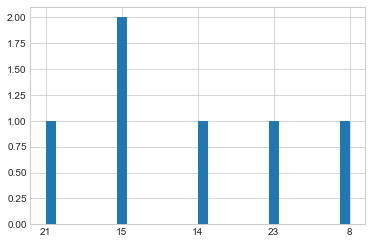

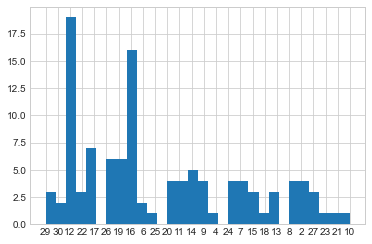

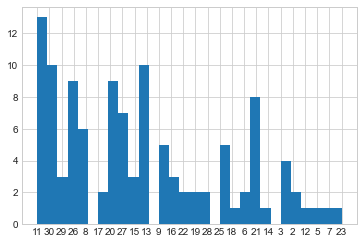

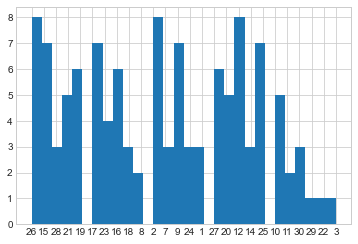

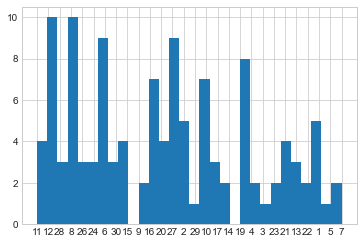

In [85]:
df.loc[df["63"]==0, "class"].hist(bins=30)
plt.show()

df.loc[df["356"]==1, "class"].hist(bins=30)
plt.show()

df.loc[df["270"]==1, "class"].hist(bins=30)
plt.show()

df.loc[df["378"]==1, "class"].hist(bins=30)
plt.show()

df.loc[df["420"]==1, "class"].hist(bins=30)
plt.show()

How about the correlation between the variables?

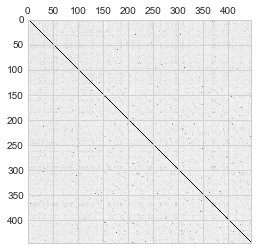

4

In [86]:
correlation_matrix = df.corr()
plt.matshow(correlation_matrix)
plt.show()

correlation_matrix[(correlation_matrix < 1) &
                   (abs(correlation_matrix) >= 0.95)].count().sum()

We create a pandas profile report to analyze each variable and their interdependences

In [87]:
#profile = ProfileReport(df, title="Locations Dataset")
#profile.to_notebook_iframe()
#profile.to_file("locations_dataset_report.html")

## Model Training

We shuffle the rows to avoid a given ordering and perform a train-test split

In [105]:
df = df.sample(frac=1)

X = df.iloc[:, 1:]
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

### KNN

Lets have a look, how well the model performs for different k's:

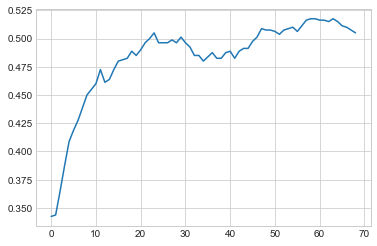

In [19]:
scores = []
for k in range(1, 70):
    neigh = KNeighborsClassifier(n_neighbors=k, p=1, metric='minkowski')
    neigh.fit(X_train, y_train)
    scores.append(neigh.score(X_test, y_test))
    
plt.plot(scores)

Through 10-fold CV we get more reliable accuracies:

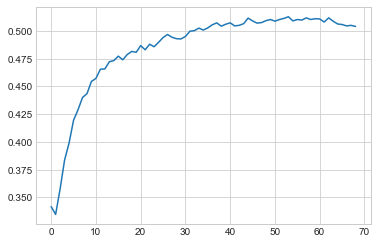

In [21]:
avg_scores = []
for k in range(1, 70):
    knn_cv = KNeighborsClassifier(n_neighbors=k, p=1, metric='minkowski')
    cv_scores = cross_val_score(knn_cv, X, y, cv=10)
    avg_score = np.mean(cv_scores)
    avg_scores.append(avg_score)
    
plt.plot(avg_scores)

Can we improve the performance by adding distance wheights?

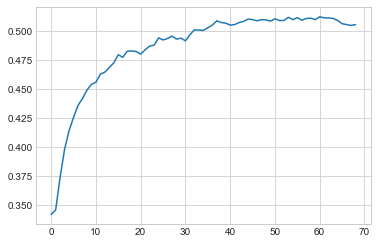

In [22]:
avg_scores_weights = []
for k in range(1, 70):
    knn_cv = KNeighborsClassifier(n_neighbors=k, weights='distance', p=1, metric='minkowski')
    cv_scores = cross_val_score(knn_cv, X, y, cv=10)
    avg_score = np.mean(cv_scores)
    avg_scores_weights.append(avg_score)
    
plt.plot(avg_scores_weights)

NO: Adding wheights does not improve the performance. Also we notice, that few neighbours have very low performance, so we will skip them in the following.

The performance is not quite satisfying yet. We have a lot of variables in our dataset. Maybe we can concentrate the information onto fewer variables through PCA:

 Step 69 is done.

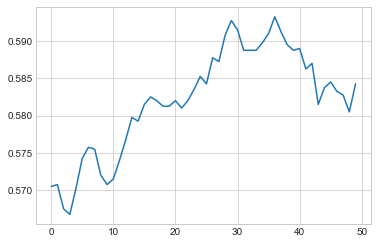

In [28]:
pca = PCA(n_components=15, random_state=42)

pca25_knn_scores = []
for k in range(20, 70):
    knn_cv = KNeighborsClassifier(n_neighbors=k, p=1, metric='minkowski')
    model = make_pipeline(pca, knn_cv)
    cv_scores = cross_val_score(model, X, y, cv=10)
    avg_score = np.mean(cv_scores)
    pca25_knn_scores.append(avg_score)
    print(f"\r Step {k} is done.", end="")

plt.plot(pca25_knn_scores)

YES: We can improve the performance through PCA-preprocessing. But how many PC-s should we use. Lets do some hyperparameter tuning.

Best parameter (CV score=0.591):
{'knn__n_neighbors': 40, 'pca__n_components': 15}


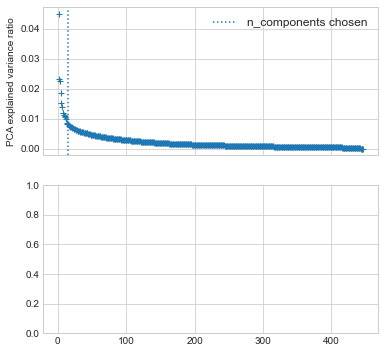

In [34]:
pca = PCA()
knn = KNeighborsClassifier(p=1, metric='minkowski')
pipe = Pipeline(steps=[("pca", pca), ("knn", knn)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 64, 80, 120, 150, 200],
    "knn__n_neighbors": range(5, 100, 5),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

### Random Forest

 200 / 200

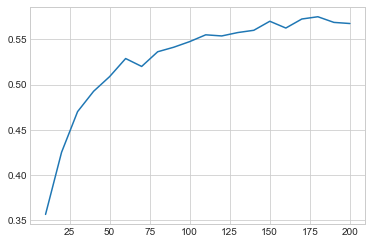

In [116]:
max_estimators = 200

estimators = range(10, max_estimators+1, 10)
scores = []
for k in estimators:
    rf = RandomForestClassifier(n_estimators = k, random_state = 42)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))
    print(f"\r {k} / {max_estimators}", end="")
    
plt.plot(estimators, scores)

 200 / 200

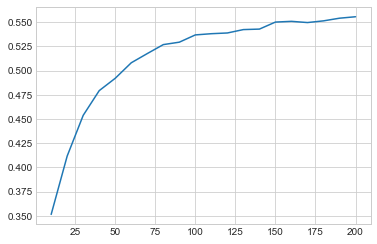

In [119]:
avg_scores = []
for k in estimators:
    rf = RandomForestClassifier(n_estimators = k, random_state = 42)
    cv_scores = cross_val_score(rf, X, y, cv=4)
    avg_score = np.mean(cv_scores)
    avg_scores.append(avg_score)
    print(f"\r {k} / {max_estimators}", end="")
    
plt.plot(estimators, avg_scores)

Since it takes forever to claculate accuracies via CV, lets compare how much simple hold-out and cv accuracies differ:

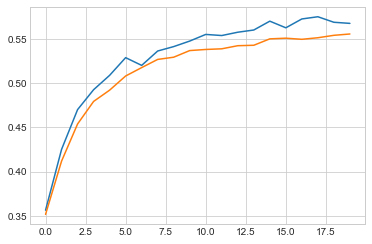

In [120]:
plt.plot(scores)
plt.plot(avg_scores)

OK, we should use CV for hyperparameter optimization, but lower fold number is enough

Does PCA help?

 Step 200 is done.

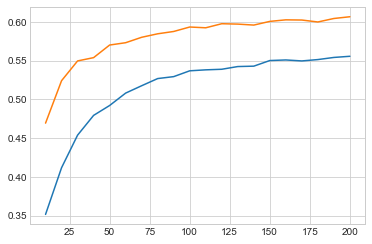

In [121]:
pca = PCA(n_components=15, random_state=42)

pca25_rf_scores = []
for k in estimators:
    rf = RandomForestClassifier(n_estimators = k, random_state = 42)
    model = make_pipeline(pca, rf)
    cv_scores = cross_val_score(model, X, y, cv=4)
    avg_score = np.mean(cv_scores)
    pca25_rf_scores.append(avg_score)
    print(f"\r {k} / {max_estimators}", end="")

plt.plot(estimators, avg_scores)
plt.plot(estimators, pca25_rf_scores)

YES: Do some hyperparametertuning

In [ ]:
rf = RandomForestClassifier(random_state = 42)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'max_depth': [None, 50, 100, 250, 600],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 4, 8, 12],
    'n_estimators': estimators
}
search = GridSearchCV(rf, param_grid, n_jobs=-1, cv=4)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

### SVM

 4 / 4

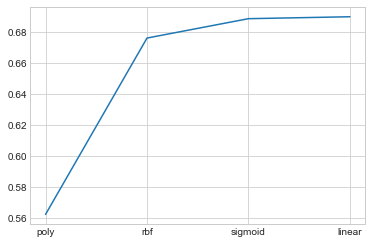

In [133]:
kernels = ["poly", "rbf", "sigmoid", "linear"]
scores = []
for i, k in enumerate(kernels):
    svm = SVC(kernel=k, random_state = 42)
    svm.fit(X_train, y_train)
    scores.append(svm.score(X_test, y_test))
    print(f"\r {i+1} / {len(kernels)}", end="")
    
plt.plot(kernels, scores)

# Hold Out vs. CV

Function to compare the average hold out acores with the average cv scores

In [141]:
def hold_out_vs_cross_validation(models, X_preprocessed, y_preprocessed, k_folds = 5, n_seeds = 50):
    # models should be a dict with keys: "knn", "r_forest" and "svm". 
    # Each entry of the dict should be the respective (untrained) model with the best hyperparameters.
    
    score = {"ho_mean": None, "ho_std": None, "cv_mean": None, "cv_std": None, "ho_scores": [], "cv_scores": []}
    model_scores = {"accuracy": copy.deepcopy(score), "f1": copy.deepcopy(score)}
    scores = {"knn": copy.deepcopy(model_scores), 
              "r_forest": copy.deepcopy(model_scores), 
              "svm": copy.deepcopy(model_scores)}

    for rnd_seed in range(1, n_seeds+1, 1):
        X, y = shuffle(X_preprocessed, y_preprocessed, random_state=rnd_seed)
        
        for model_name in models:
            # Calculate hold-out scores
            model = models[model_name]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/k_folds, shuffle = False)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            ho_accuracy = accuracy_score(y_test, y_pred)
            ho_f1 = f1_score(y_test, y_pred, average='macro') # Use macro averaging
            
            scores[model_name]["accuracy"]["ho_scores"].append(ho_accuracy)
            scores[model_name]["f1"]["ho_scores"].append(ho_f1)
            
            # Calculate CV scores
            model = models[model_name]
            
            cv_accuracy = cross_val_score(model, X, y, scoring="accuracy", n_jobs=-1, cv=10)
            cv_f1 = cross_val_score(model, X, y, scoring="f1_macro", n_jobs=-1, cv=10)
            
            scores[model_name]["accuracy"]["cv_scores"].append(cv_accuracy)
            scores[model_name]["f1"]["cv_scores"].append(cv_f1)
        
        print(f"\r Scores calculated for random seed {rnd_seed} / {n_seeds}", end="")
    
    for model_name in models:
        print(f"\n\n{model_name}")
        for score_name in model_scores:
            print(f"   {score_name}:")
            ho_mean = np.mean(scores[model_name][score_name]["ho_scores"])
            ho_std = np.std(scores[model_name][score_name]["ho_scores"])
            cv_mean = np.mean(scores[model_name][score_name]["cv_scores"])
            cv_std = np.std(scores[model_name][score_name]["cv_scores"])
            
            scores[model_name][score_name]["ho_mean"] = ho_mean
            scores[model_name][score_name]["ho_std"] = ho_std
            scores[model_name][score_name]["cv_mean"] = cv_mean
            scores[model_name][score_name]["cv_std"] = cv_std
            
            print(f"      Average Hold-out {score_name}: {round(ho_mean, 5)} +- {round(ho_std, 5)}")
            print(f"      Average    CV    {score_name}: {round(cv_mean, 5)} +- {round(cv_std, 5)}")
    
    return(scores)

Test the Function:

In [142]:
knn = KNeighborsClassifier(n_neighbors = 40, p = 1, metric = 'minkowski')
rf = RandomForestClassifier(n_estimators = 200)
svm = SVC(kernel="linear", random_state = 42)

best_models = {"knn": knn, "r_forest": rf, "svm": svm}

ho_vs_cv_scores = hold_out_vs_cross_validation(models = best_models, X_preprocessed = X, y_preprocessed = y, k_folds = 5, n_seeds = 5)

 Scores calculated for random seed 5 / 5

knn
   accuracy:
      Average Hold-out accuracy: 0.4935 +- 0.01182
      Average    CV    accuracy: 0.50315 +- 0.01771
   f1:
      Average Hold-out f1: 0.44288 +- 0.01012
      Average    CV    f1: 0.44654 +- 0.02313


r_forest
   accuracy:
      Average Hold-out accuracy: 0.55825 +- 0.01468
      Average    CV    accuracy: 0.55965 +- 0.02488
   f1:
      Average Hold-out f1: 0.52544 +- 0.01461
      Average    CV    f1: 0.52504 +- 0.02576


svm
   accuracy:
      Average Hold-out accuracy: 0.68875 +- 0.00487
      Average    CV    accuracy: 0.70075 +- 0.02566
   f1:
      Average Hold-out f1: 0.67766 +- 0.00637
      Average    CV    f1: 0.69213 +- 0.02518
